## Data simulation in scib

Code from https://github.com/theislab/scib-reproducibility/tree/main/notebooks/data_preprocessing/simulations. Simulation were generated using the Splatter package.

In [1]:
proj_name = "simulate_batch_scib"
data_dir = paste0("../data/", proj_name, "/")
dir.create(data_dir)
save_dir = paste0("../save/", proj_name, format(Sys.time(), "%b%d"), "/")
dir.create(save_dir)
seed = 0
set.seed(seed)

Warning message in dir.create(data_dir):
"'../data/simulate_batch_scib' already exists"
Warning message in dir.create(save_dir):
"'../save/simulate_batch_scibOct14' already exists"


In [5]:
library(splatter)

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: 'MatrixGenerics'


The following objects are masked from 'package:matrixStats':

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    

In [18]:
#' Sample group proportions
#'
#' Downsample a Splat simulation to get the desired cell proportions
#'
#' @param sim SingleCellExperiment containing a Splat simulation
#' @param batch_ncells Final number of cells in each batch
#' @param batch_props Final cell proportions in each batch
#'
#' @return Downsampled SingleCellExperiment object
sample_group_props <- function(sim, batch_ncells, batch_props) {

    # Get the cell metadata
    col_data <- as.data.frame(colData(sim))

    # Get the current counts of each group in each batch
    sim_batch_group_count <- table(col_data$Batch, col_data$Group)

    # Get the final number of each group in each batch
    batch_group_ncells <- lapply(seq_along(batch_ncells), function(idx) {
        batch_ncells[idx] * batch_props[[idx]]
    })

    # Check that we aren't trying to get more cells than we have
    lapply(seq_along(batch_group_ncells), function(idx) {
        if (any(batch_group_ncells[[idx]] > sim_batch_group_count[idx, ])) {
            stop("Not enough cells for these proportions in batch ", idx)
        }
    })

    # Downsample cells
    selected <- lapply(seq_along(batch_group_ncells), function(batch) {
        group_cells <- batch_group_ncells[[batch]]
        is_batch <- col_data$Batch == paste0("Batch", batch)
        batch_groups <- col_data$Group[is_batch]
        # Downsample batch
        selected_batch <- sapply(seq_along(group_cells), function(group) {
            is_group <- batch_groups == paste0("Group", group)
            sample(col_data$Cell[is_batch][is_group], group_cells[group])
        })
        unlist(selected_batch)
    })
    selected <- as.character(unlist(selected))

    # Subset SingleCellExperiment
    sim[, selected]
}

In [19]:
base_params <- newSplatParams()

sim1_params <- setParams(
    base_params,
    lib.loc        = 12,
    # Six batches with 10000 cells each. Needs to be more than we want in the
    # final simulation.
    batchCells     = c(1000, 1000, 1000, 1000, 1000, 1000) * 10,
    batch.facLoc   = c(0.10, 0.15, 0.12, 0.18, 0.15, 0.25),
    batch.facScale = c(0.10, 0.08, 0.12, 0.10, 0.12, 0.18),
    # Groups with equal probabilities
    group.prob     = rep(1, 7) / 7,
    # Differential expression by group
    de.prob        = c(0.10, 0.12, 0.08, 0.20, 0.12, 0.10, 0.16),
    de.facLoc      = c(0.10, 0.08, 0.12, 0.18, 0.06, 0.20, 0.14),
    de.facScale    = c(0.40, 0.30, 0.45, 0.48, 0.42, 0.38, 0.36),
    # Seed
    seed           = 1
)

# Simulate the full dataset that we will downsample
sim1_full <- splatSimulateGroups(sim1_params)


Getting parameters...

Creating simulation object...

Simulating library sizes...

Simulating gene means...

Simulating batch effects...

Simulating group DE...

Simulating cell means...

Simulating BCV...

Simulating counts...

Simulating dropout (if needed)...

Sparsifying assays...

Automatically converting to sparse matrices, threshold = 0.95

Skipping 'BatchCellMeans': estimated sparse size 1.5 * dense matrix

Skipping 'BaseCellMeans': estimated sparse size 1.5 * dense matrix

Skipping 'BCV': estimated sparse size 1.5 * dense matrix

Skipping 'CellMeans': estimated sparse size 1.49 * dense matrix

Skipping 'TrueCounts': estimated sparse size 2.12 * dense matrix

Skipping 'counts': estimated sparse size 2.12 * dense matrix

Done!



In [20]:
dim(sim1_full)

[1] 10000 60000

In [21]:
# Number of cells in each batch in the final simulation
batch_ncells <- c(300, 250, 220, 200, 180, 100) * 10
# Proportions in each group in each batch that we want. Should sum to 1.
batch_props <- list(
    c(0.35, 0.22, 0.15, 0.13, 0.10, 0.05, 0.00),
    c(0.25, 0.33, 0.20, 0.10, 0.00, 0.08, 0.04),
    c(0.30, 0.30, 0.00, 0.20, 0.10, 0.10, 0.00),
    c(0.15, 0.20, 0.35, 0.15, 0.15, 0.00, 0.00),
    c(0.40, 0.05, 0.10, 0.10, 0.17, 0.12, 0.06),
    c(0.45, 0.35, 0.15, 0.05, 0.00, 0.00, 0.00)
)

In [22]:
# Downsample cells in our simulation
message("Downsampling cells...")
sim1 <- sample_group_props(sim1_full, batch_ncells, batch_props)

Downsampling cells...



In [30]:
batch_count_props <- c(
    Batch1 = 0.30,
    Batch2 = 0.25,
    Batch3 = 0.32,
    Batch4 = 0.45,
    Batch5 = 0.28,
    Batch6 = 1.00
)
cell_count_props <- batch_count_props[colData(sim1)$Batch]


In [31]:
message("Downsampling counts...")
counts(sim1) <- DropletUtils::downsampleMatrix(counts(sim1), cell_count_props,
                                               bycol = TRUE)

Downsampling counts...



In [32]:
sim1

class: SingleCellExperiment 
dim: 10000 12500 
metadata(1): Params
assays(7): BatchCellMeans BaseCellMeans ... counts logcounts
rownames(10000): Gene1 Gene2 ... Gene9999 Gene10000
rowData names(17): Gene BaseGeneMean ... DEFacGroup6 DEFacGroup7
colnames(12500): Cell9517 Cell5323 ... Cell57940 Cell53110
colData names(9): Cell Batch ... Discard sizeFactor
reducedDimNames(1): TSNE
mainExpName: NULL
altExpNames(0):

In [33]:
sim1 <- scater::addPerCellQC(sim1)

discard <- lapply(unique(colData(sim1)$Batch), function(batch) {
    in_batch <- colData(sim1)$Batch == batch
    scater::quickPerCellQC(colData(sim1)[in_batch, ], nmads = 2)$discard
})
discard <- unlist(discard)
colData(sim1)$Discard <- discard

In [34]:
table(colData(sim1)$Discard)


FALSE  TRUE 
12097   403 

In [35]:
message("Filtering cells...")
sim1_qc <- sim1[, !discard]
message("Filtering genes...")
sim1_qc <- scater::addPerFeatureQC(sim1_qc)
is_exprs <- rowData(sim1_qc)$detected >= 0.01
sim1_qc <- sim1_qc[is_exprs, ]


Filtering cells...

Filtering genes...



In [36]:
message("Normalising...")
sim1 <- scater::logNormCounts(sim1)
sim1_qc <- scater::logNormCounts(sim1_qc)
message("Embedding...")
sim1 <- scater::runTSNE(sim1)
sim1_qc <- scater::runTSNE(sim1_qc)

Normalising...

Embedding...



In [38]:
save_dir

[1] "../save/simulate_batch_scibOct14/"

Saving QC plots..

Saving 7 x 7 in image


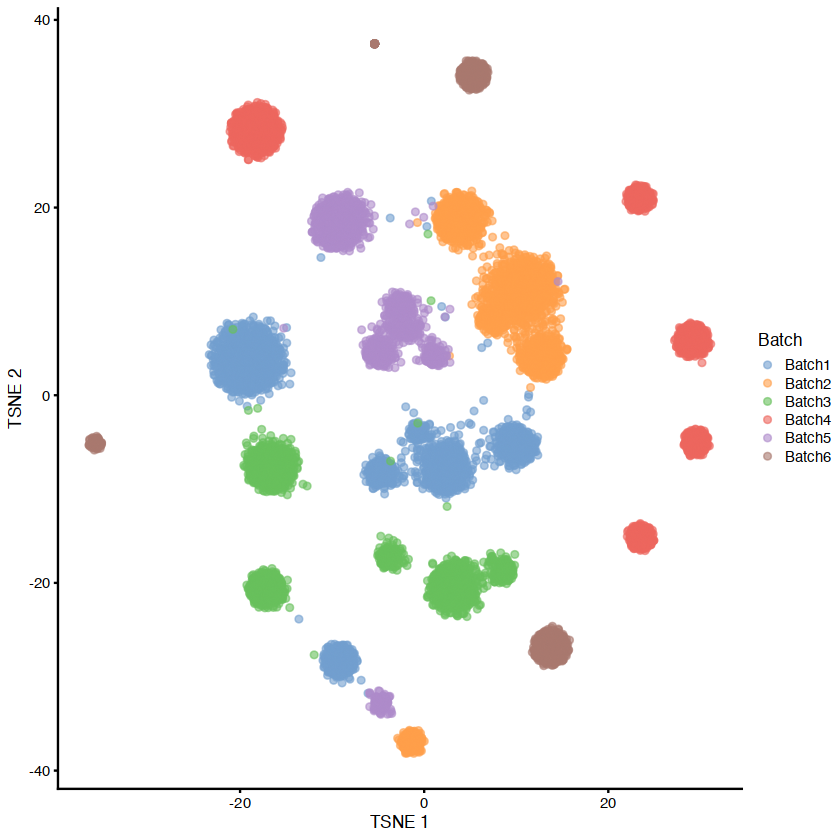

Saving 7 x 7 in image


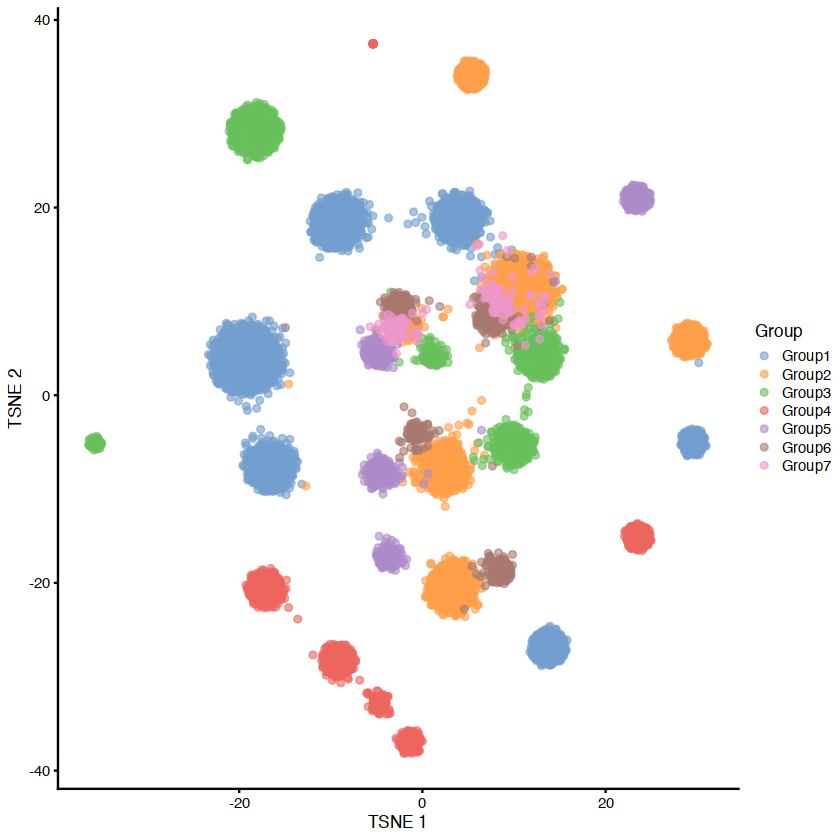

Saving 7 x 7 in image


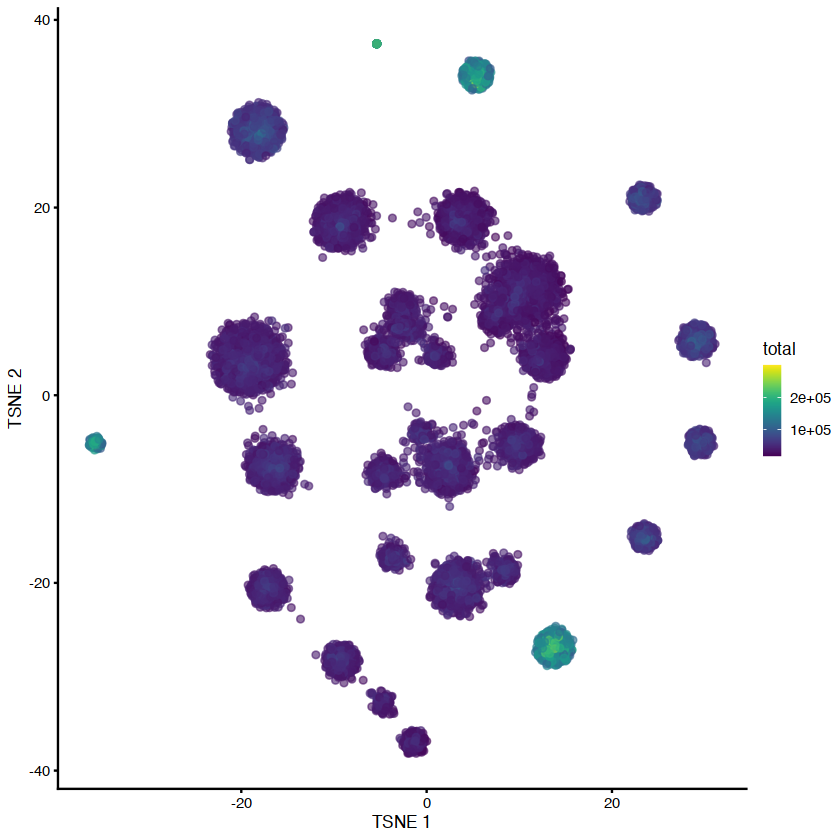

Saving 7 x 7 in image


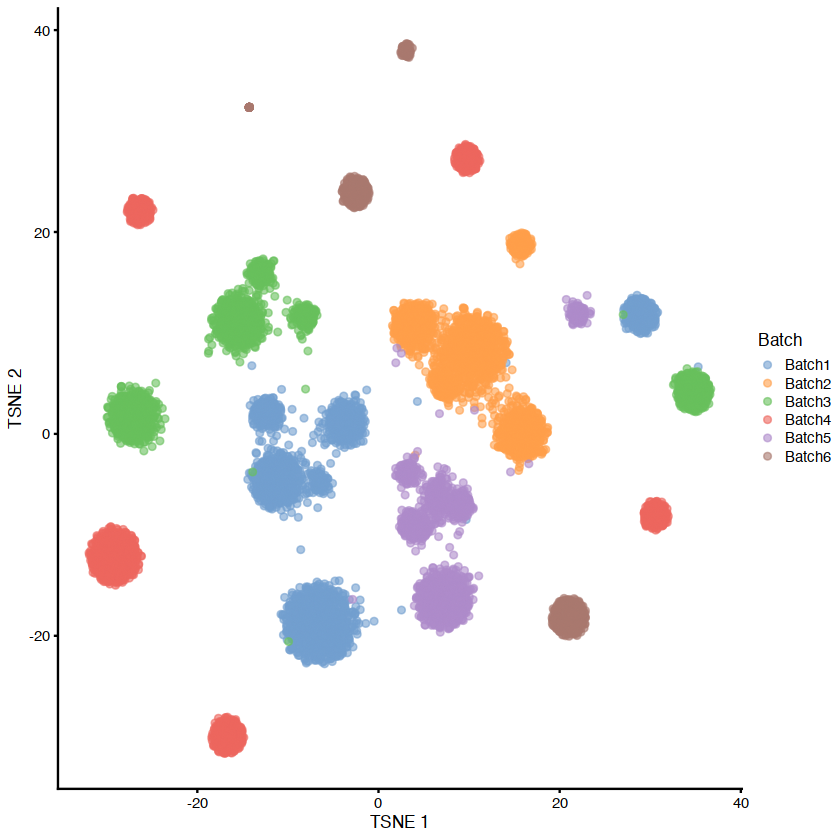

Saving 7 x 7 in image


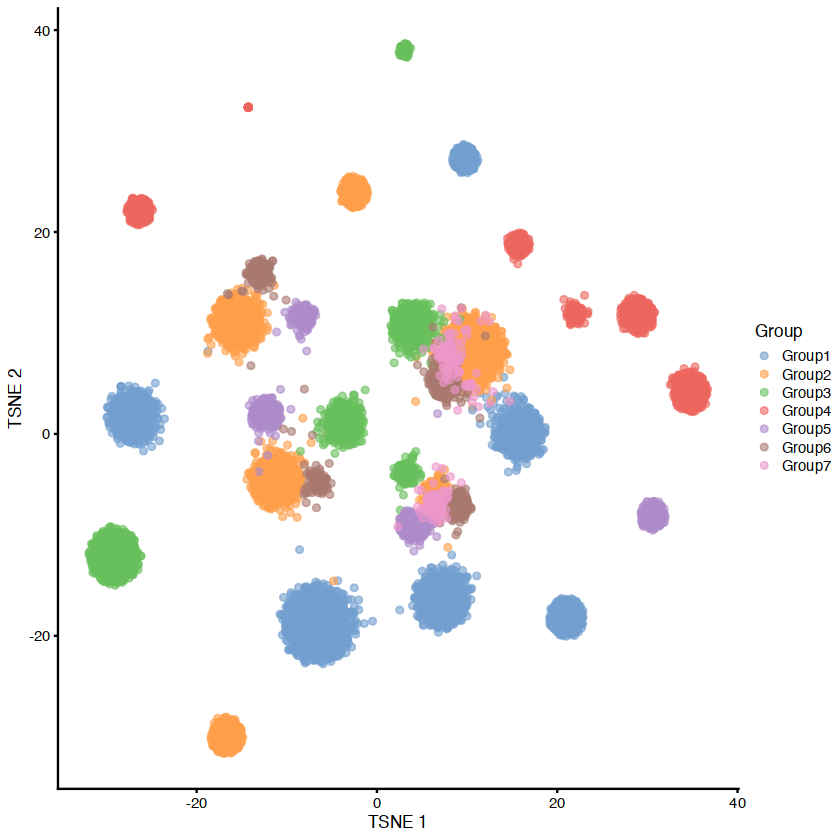

Saving 7 x 7 in image


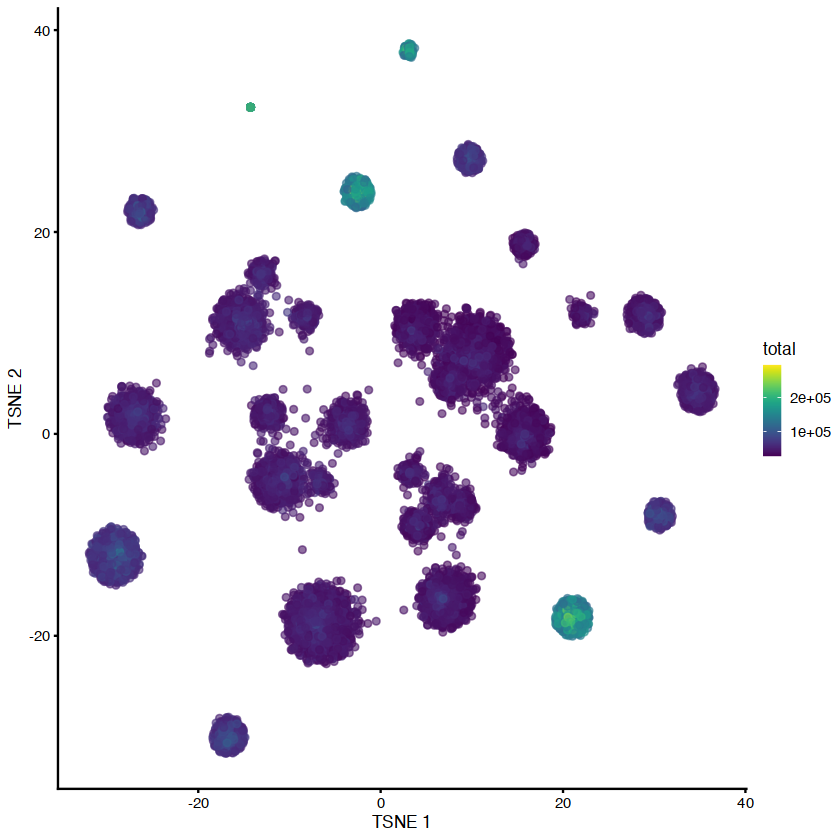

Saving 7 x 7 in image


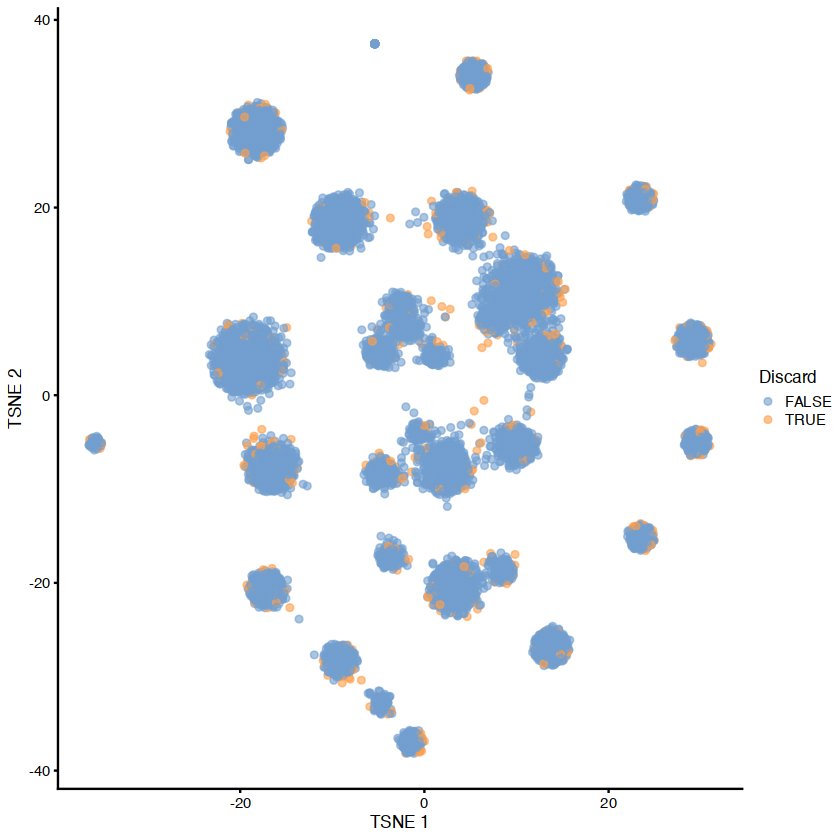

Saving 7 x 7 in image


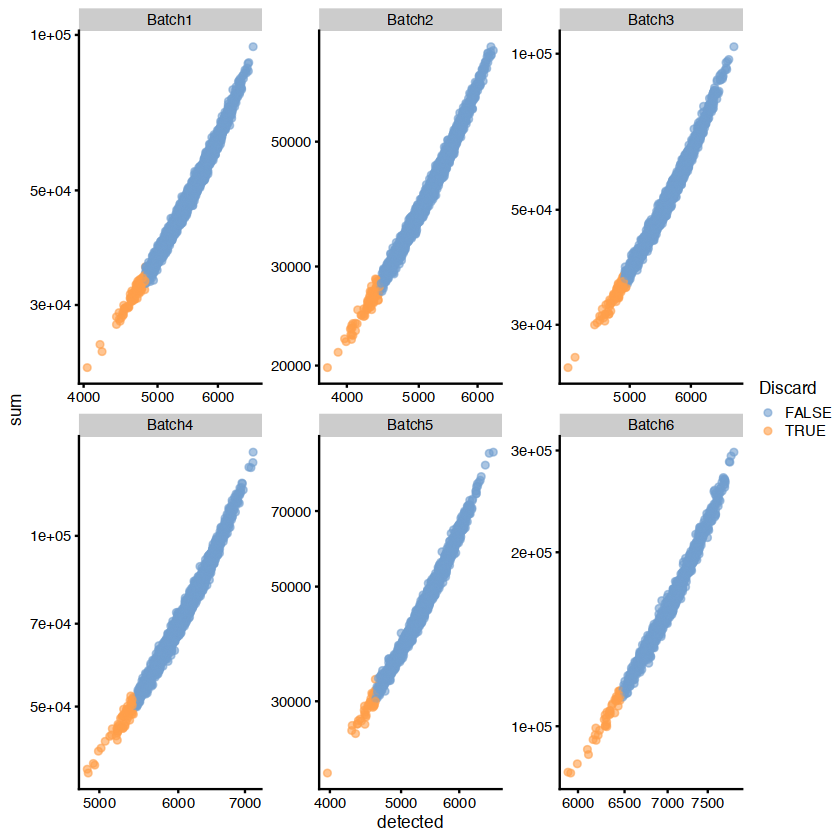

In [39]:
message("Saving QC plots..")
fs::dir_create(paste0(save_dir, "qc_plots/sim1"))

scater::plotTSNE(sim1, colour_by = "Batch")
ggplot2::ggsave(paste0(save_dir, "qc_plots/sim1/tsne-batch.png"))
scater::plotTSNE(sim1, colour_by = "Group")
ggplot2::ggsave(paste0(save_dir, "qc_plots/sim1/tsne-group.png"))
scater::plotTSNE(sim1, colour_by = "total")
ggplot2::ggsave(paste0(save_dir, "qc_plots/sim1/tsne-total.png"))
scater::plotTSNE(sim1_qc, colour_by = "Batch")
ggplot2::ggsave(paste0(save_dir, "qc_plots/sim1/tsne-batch-qc.png"))
scater::plotTSNE(sim1_qc, colour_by = "Group")
ggplot2::ggsave(paste0(save_dir, "qc_plots/sim1/tsne-group-qc.png"))
scater::plotTSNE(sim1_qc, colour_by = "total")
ggplot2::ggsave(paste0(save_dir, "qc_plots/sim1/tsne-total-qc.png"))
scater::plotTSNE(sim1, colour_by = "Discard")
ggplot2::ggsave(paste0(save_dir, "qc_plots/sim1/tsne-filt.png"))
scater::plotColData(sim1, "sum", "detected", colour_by = "Discard",
                    other_fields = "Batch") +
    ggplot2::scale_x_log10() +
    ggplot2::scale_y_log10() +
    ggplot2::facet_wrap(~ Batch, scales = "free")
ggplot2::ggsave(paste0(save_dir, "qc_plots/sim1/filtering.png"))

In [46]:
# Remove intermediate matrices to reduce file size

assays(sim1) <- assays(sim1)[assayNames(sim1) == "counts"]
assays(sim1_qc) <- assays(sim1_qc)[assayNames(sim1_qc) == "counts"]
saveRDS(sim1, paste0(data_dir, "sim1.Rds"))
saveRDS(sim1_qc, paste0(data_dir, "sim1_qc.Rds"))

In [2]:
sim1 = readRDS(paste0(data_dir, "sim1.Rds"))
sim1_qc = readRDS(paste0(data_dir, "sim1_qc.Rds"))

In [3]:
library(reticulate)
use_condaenv("concord", required = TRUE)

In [6]:
message("Converting to AnnData...")
anndata <- reticulate::import("anndata")
sim1_adata <- anndata$AnnData(
    X = t(counts(sim1)),
    obs = data.frame(colData(sim1)),
    var = data.frame(rowData(sim1))
)
sim1_qc_adata <- anndata$AnnData(
    X = t(counts(sim1_qc)),
    obs = data.frame(colData(sim1_qc)),
    var = data.frame(rowData(sim1_qc))
)

Converting to AnnData...



In [7]:
message("Saving simulation...")
sim1_adata$write(filename = paste0(data_dir, "sim1.h5ad"))
sim1_qc_adata$write(filename = paste0(data_dir, "sim1_qc.h5ad"))

Saving simulation...



In [8]:
dim(sim1_qc)

[1]  9953 12097

In [9]:
ds_genes = sample(rownames(sim1_qc), 1000)
ds_cells = sample(colnames(sim1_qc), 1000)
sim1_qc_ds = sim1_qc[ds_genes, ds_cells]

Saving 7 x 7 in image


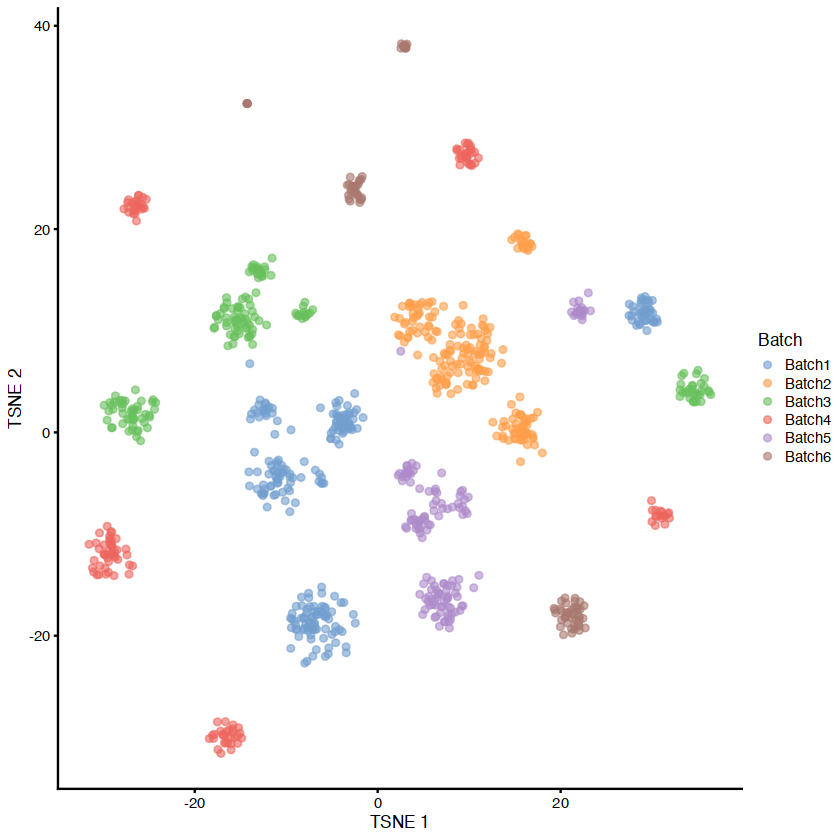

Saving 7 x 7 in image


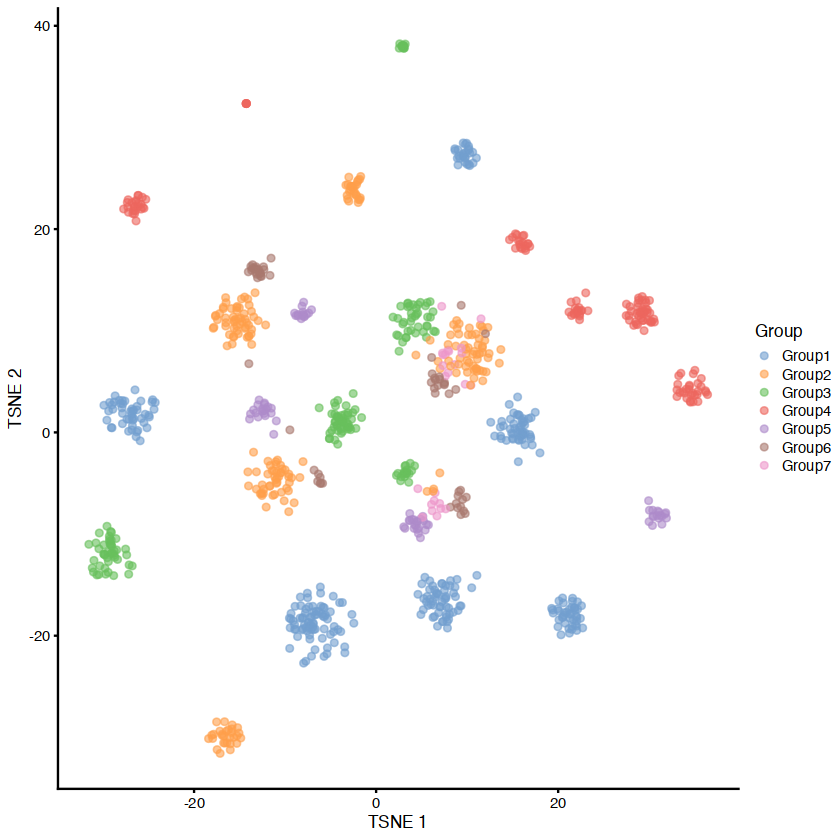

In [11]:
scater::plotTSNE(sim1_qc_ds, colour_by = "Batch")
ggplot2::ggsave(paste0(save_dir, "qc_plots/sim1/tsne-batch-qc-ds.png"))
scater::plotTSNE(sim1_qc_ds, colour_by = "Group")
ggplot2::ggsave(paste0(save_dir, "qc_plots/sim1/tsne-group-qc-ds.png"))

In [13]:
sim1_qc_ds <- scater::logNormCounts(sim1_qc_ds)

In [19]:
assay(sim1_qc_ds, "logcounts")

  [[ suppressing 32 column names 'Cell27680', 'Cell403', 'Cell4605' ... ]]



1000 x 1000 sparse Matrix of class "dgCMatrix"
                                                                         
Gene9661 1.156844 .        .        .         0.5242316 .        1.498528
Gene1023 1.156844 1.122910 1.084570 2.1061114 1.8595738 1.828463 .       
Gene8044 .        .        .        .         0.5242316 .        .       
Gene4802 .        .        1.084570 .         .         .        .       
Gene9772 1.790514 3.802860 2.454958 2.3594132 4.5178028 2.271240 1.498528
Gene8503 .        .        1.084570 .         .         .        .       
Gene4073 .        .        .        .         .         .        .       
Gene8833 1.156844 .        .        2.5748134 2.3055347 .        .       
Gene1308 .        .        .        .         0.9079172 1.186369 1.498528
Gene8563 .        .        1.696655 .         1.2107019 1.186369 .       
Gene1808 1.156844 .        .        .         .         .        .       
Gene9988 .        .        .        .         1.6739349 1.186369 

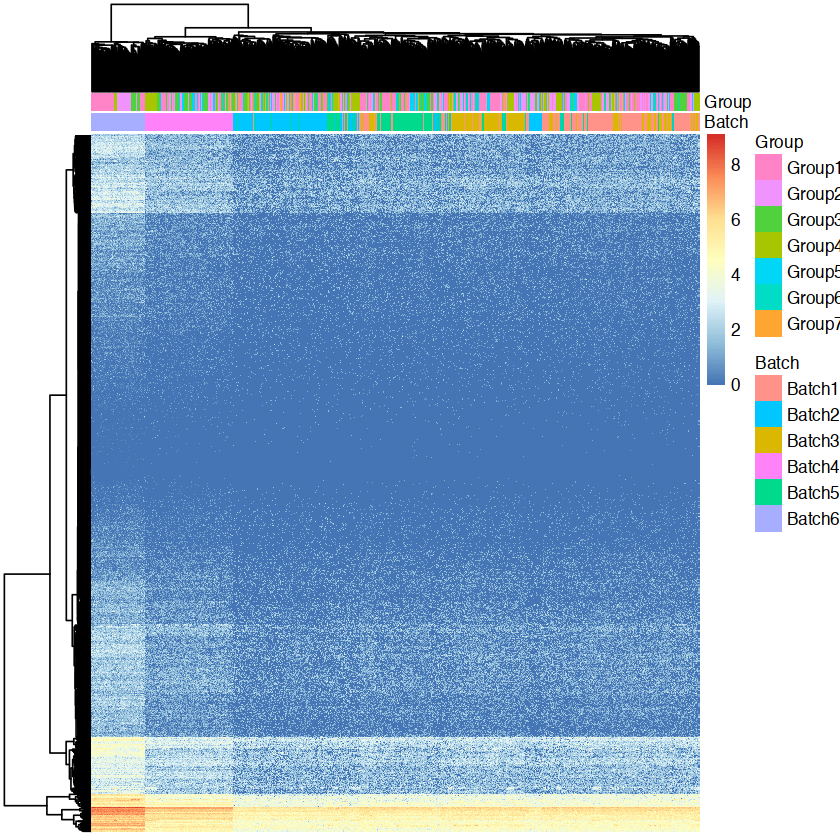

In [31]:
annotation_col <- as.data.frame(colData(sim1_qc_ds)[, c("Batch", "Group")])
rownames(annotation_col) <- colnames(assay(sim1_qc_ds, "logcounts"))

library(pheatmap)
pheatmap(as.matrix(assay(sim1_qc_ds, "logcounts")),
         annotation_col = annotation_col,  
         show_rownames = FALSE,            
         show_colnames = FALSE, 
         width = 10, height = 10)

In [29]:
sum(!complete.cases(annotation_col))

[1] 0